In [55]:
from datasets import Dataset, load_from_disk
import evaluate
import numpy as np
import os
from optuna.visualization.matplotlib import plot_param_importances
import pandas as pd
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from setfit import SetFitModel, SetFitTrainer, sample_dataset
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import BertForSequenceClassification, BertTokenizerFast, get_linear_schedule_with_warmup
from tqdm.auto import tqdm
from typing import List, Dict, Any

dir_path = os.path.dirname(os.path.realpath(os.getcwd()))
data_path = os.path.join(dir_path, "data", "wice")
save_dir = os.path.join(dir_path, "models", "setfit", "wice_classifier")

### Miscellaneous helper functions

In [56]:
def binary_indices(row_data: pd.Series) -> List:
    """
    Convert list of indices to list of binary values indicating whether the corresponding
    evidence sentence supports or not.

    Args:
        row_data (Series): row of WiCE dataset to apply changes to.

    Returns:
        List: list of binary values corresponding to the list of sentences in the 'evidence' column,
        where 0's are for 'not support' sentences and 1's for 'support' sentences.
    """
    indices = set(item for sublist in row_data["supporting_sentences"] for item in sublist)
    binary_array = [int(i in indices) for i in range(len(row_data["evidence"]))]
    return binary_array


def prepare_wice_data() -> (pd.DataFrame, pd.DataFrame):
    """
    Loads WiCE train and dev data and formats the data for model training.
    Note: train and dev files from `https://github.com/ryokamoi/wice/data/entailment_retrieval/claims`

    Returns:
        (DataFrame, DataFrame): train and dev dataframes with just the evidence and supporting sentences as columns.
    """

    df_train = pd.read_json(f"{data_path}/train.jsonl", lines=True)
    df_train["label"] = df_train.apply(binary_indices, axis=1)
    df_train.drop(["supporting_sentences", "claim", "meta"], axis=1, inplace=True)

    df_dev = pd.read_json(f"{data_path}/dev.jsonl", lines=True)
    df_dev["label"] = df_dev.apply(binary_indices, axis=1)
    df_dev.drop(["supporting_sentences", "claim", "meta"], axis=1, inplace=True)

    df_train = df_train.explode(["label", "evidence"], ignore_index=True)
    df_dev = df_dev.explode(["label", "evidence"], ignore_index=True)

    return df_train, df_dev

def compute_metrics(labels: List, preds: List) -> Dict:
    """
    Calculates metrics during training and/or evaluation

    Args:
        labels (List): List of true labels.
        preds (List): List of predicted labels.

    Returns:
        Dict: various metric values
    """
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0.0)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def subsample_train(dataframe: pd.DataFrame):
    minority_df = dataframe[dataframe['labels'] == 1]
    majority_df = dataframe[dataframe['labels'] == 0]
    subsample_major = majority_df.sample(n=5000)
    result = pd.concat([minority_df, subsample_major])
    result = result.sample(frac=1).reset_index(drop=True)
    return Dataset.from_pandas(result)


## SetFit

In [ ]:
def model_init(params: Any, use_setfithead=False):
    """
    Initialises SetFit model with parameters.
    """

    if use_setfithead:
        params = {
            "use_differentiable_head": True,
            "head_params": {
                "out_features": 2
            }
        }
    else:
        params = params or {}
        max_iter = params.get("max_iter", 200)
        solver = params.get("solver", "liblinear")
        params = {
            "head_params": {
                "max_iter": max_iter,
                "solver": solver,
            }
        }

    # Load SetFit Model.
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    checkpoint = "sentence-transformers/paraphrase-mpnet-base-v2"
    model = SetFitModel.from_pretrained(checkpoint, **params).to(device=device)
    if not use_setfithead:
        model.model_head = LogisticRegression(class_weight='balanced')
    return model

def hp_space(trial: Any):
    """
    Hyperparameter space
    """
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-8, 1e-4, log=True),
        "num_epochs": trial.suggest_int("num_epochs", 1, 10),
        "batch_size": trial.suggest_categorical("batch_size", [4, 8, 16, 32]),
        "num_iterations": trial.suggest_int("num_iterations", 5, 20),
        "max_iter": trial.suggest_int("max_iter", 50, 500),
        "solver": trial.suggest_categorical("solver", ["lbfgs", "liblinear", "saga"]),
    }

def my_objective(metrics: Any) -> Any:
    """
    Objective metric to optimize for

    Args:
        metrics: metric(s) from which to optimize for
    
    Returns:
        Any: a single metric
    """
    return metrics['f1']

def save_run(run: Any) -> None:
    """
    Save BestRun object containing model parameters after hyperparameter tuning as pickle.

    Args:
        run (Any): setfit BestRun object to store
    """
    with open(f"{save_dir}/best_run.pkl", "wb") as file:
        pickle.dump(run, file)

def load_run(file_location=None) -> Any:
    """
    Loads BestRun object containing model parameters for instantiating a SetFitmodel.

    Args:
        file_location: string containing the file location
    
    Returns:
        Any: setfit BestRun object
    """
    file_location = f"{save_dir}/best_run.pkl" if not file_location else file_location
    with open(file_location, "rb") as file:
        return pickle.load(file)

### Hyperparameter tuning

In [3]:
def setfit_hyperparameter_tuning(n_samples=16) -> None:
    """
    Performs hyperparameter tuning on Setfit

    Args:
        n_samples (Int): amount of training samples to take per class label
    """
    
    train_data, dev_data = prepare_wice_data()
    train_dataset_full = Dataset.from_pandas(train_data)
    train_dataset_sample = sample_dataset(train_dataset_full, 
                                          num_samples=n_samples)
    val_dataset = Dataset.from_pandas(dev_data)

    trainer = SetFitTrainer(
        model_init=model_init,
        train_dataset=train_dataset_sample,
        eval_dataset=val_dataset,
        column_mapping={"evidence": "text", "label": "label"},
        metric=compute_metrics
    )

    # Perform Hyperparameter tuning
    best_run = trainer.hyperparameter_search(direction="maximize", 
                                             hp_space=hp_space, 
                                             n_trials=100, 
                                             compute_objective=my_objective)
    print(f"\nBest Run: {best_run}")
    plot_param_importances(best_run.backend)

    # Store information
    save_run(best_run)
    train_df = Dataset.to_pandas(train_dataset_sample)
    train_df.to_csv(f'{save_dir}/tune_train.csv', index=False)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
[I 2023-11-12 11:28:00,975] A new study created in memory with name: no-name-ab0dcdec-d50c-4ccd-9667-ed3e4a74d4c7
Trial: {'learning_rate': 2.9161843612039506e-05, 'num_epochs': 5, 'batch_size': 16, 'num_iterations': 10, 'max_iter': 405, 'solver': 'lbfgs'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
Generating Training Pairs: 100%|██████████| 10/10 [00:00<00:00, 1417.95it/s]
***** Running training *****
  Num examples = 640
  Num epochs = 5
  Total optimization steps = 200
  Total train batch size = 16
Epoch: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]
Applying column mapping to evaluation dataset
***** Running ev


Best Run: BestRun(run_id='71', objective=0.143246711581649, hyperparameters={'learning_rate': 7.411716784550214e-05, 'num_epochs': 6, 'batch_size': 32, 'num_iterations': 16, 'max_iter': 455, 'solver': 'lbfgs'}, backend=<optuna.study.study.Study object at 0x7f5a0c0f5a10>)


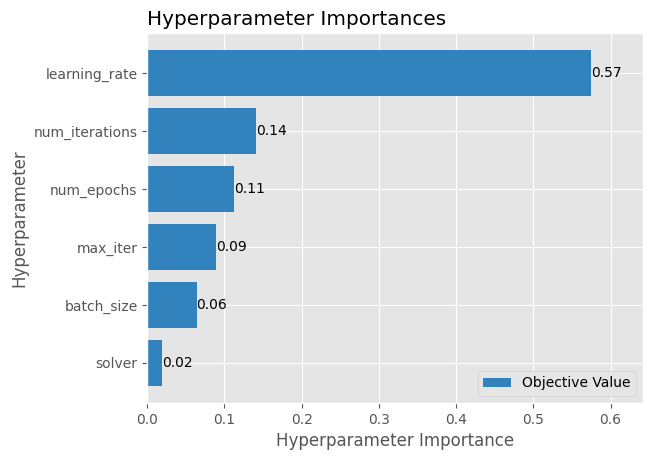

In [29]:
setfit_hyperparameter_tuning()

In [4]:
def eval_train_setfit(full_pos_label=True, store_files=False, use_setfithead=False):
    train_data, dev_data = prepare_wice_data()
    val_dataset = Dataset.from_pandas(dev_data)

    if full_pos_label:
      # Take amount of train labels corresponding to support (imbalanced compared to no support) as the total number of samples.
      nsamples = len(train_data[train_data['label'] == 1]) # ~4427 rows
      train_dataset_full = Dataset.from_pandas(train_data)
      train_dataset = sample_dataset(train_dataset_full, num_samples=nsamples)
    else:
      # Use same datasets as hypertuning
      train_dataset_full = pd.read_csv(f'{save_dir}/tune_train.csv')
      train_dataset = Dataset.from_pandas(train_dataset_full)
    

    # Instantiate with best hypertuned model parameters
    trainer = SetFitTrainer(
        model_init=model_init(use_setfithead=use_setfithead),
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        column_mapping={"evidence": "text", "label": "label"},
        metric=compute_metrics,
    )
    best_run = load_run()
    print(f"Initialize model using hypertuned parameters: {best_run}\n\n")
    trainer.apply_hyperparameters(best_run.hyperparameters, final_model=True)

    if use_setfithead:
        # Train and evaluate
        trainer.freeze() # Freeze the head
        trainer.train() # Train only the body

        # Unfreeze the head and unfreeze the body -> end-to-end training
        trainer.unfreeze(keep_body_frozen=False)

        trainer.train(
            num_epochs=25, # The number of epochs to train the head or the whole model (body and head)
            batch_size=16,
            body_learning_rate=1e-5, # The body's learning rate
            learning_rate=1e-2, # The head's learning rate
            l2_weight=0.0, # Weight decay on **both** the body and head. If `None`, will use 0.01.
        )
    else:
        # Train and evaluate
        trainer.train()

    # Get predictions
    with torch.no_grad():
        dev_data['predictions'] = trainer.model.predict(x_test=dev_data['evidence'], as_numpy=True, show_progress_bar=True)
        print(f"Metrics full-dev set: {compute_metrics(dev_data['label'].to_list(), dev_data['predictions'].to_list())}")

    # Save used datasets
    if store_files:
        train_df = Dataset.to_pandas(train_dataset)
        train_df.to_csv(f'{save_dir}/val_train.csv', index=False)
        dev_data.to_csv(f'{save_dir}/val_dev.csv', index=False)
        trainer.model._save_pretrained(save_directory=save_dir)

Sklearn classification head

In [9]:
eval_train_setfit(full_pos_label=False, store_files=True)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Initialize model using hypertuned parameters: BestRun(run_id='82', objective=0.7336765104307775, hyperparameters={'learning_rate': 7.359481282349892e-05, 'num_epochs': 1, 'batch_size': 4, 'num_iterations': 5, 'max_iter': 270, 'solver': 'saga'}, backend=<optuna.study.study.Study object at 0x7fb1f61fee50>)




model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
Generating Training Pairs: 100%|██████████| 5/5 [00:00<00:00, 1283.84it/s]
***** Running training *****
  Num examples = 320
  Num epochs = 1
  Total optimization steps = 80
  Total train batch size = 4
Batches: 100%|██████████| 1304/1304 [00:19<00:00, 66.51it/s] 


Metrics full-dev set: {'accuracy': 0.7676258992805756, 'f1': 0.11555312157721798, 'precision': 0.06670179135932561, 'recall': 0.43178717598908595}


In [10]:
eval_train_setfit(full_pos_label=True, store_files=True)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Initialize model using hypertuned parameters: BestRun(run_id='82', objective=0.7336765104307775, hyperparameters={'learning_rate': 7.359481282349892e-05, 'num_epochs': 1, 'batch_size': 4, 'num_iterations': 5, 'max_iter': 270, 'solver': 'saga'}, backend=<optuna.study.study.Study object at 0x7fb1f5e92ad0>)




model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
Generating Training Pairs: 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]
***** Running training *****
  Num examples = 88540
  Num epochs = 1
  Total optimization steps = 22135
  Total train batch size = 4
Batches: 100%|██████████| 1304/1304 [00:19<00:00, 65.77it/s] 


Metrics full-dev set: {'accuracy': 0.03515587529976019, 'f1': 0.06792382893944307, 'precision': 0.03515587529976019, 'recall': 1.0}


SetFithead classification head

In [8]:
eval_train_setfit(full_pos_label=False, store_files=True, use_setfithead=True)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Initialize model using hypertuned parameters: BestRun(run_id='82', objective=0.7336765104307775, hyperparameters={'learning_rate': 7.359481282349892e-05, 'num_epochs': 1, 'batch_size': 4, 'num_iterations': 5, 'max_iter': 270, 'solver': 'saga'}, backend=<optuna.study.study.Study object at 0x7fb3800bda50>)




model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
Generating Training Pairs: 100%|██████████| 5/5 [00:00<00:00, 1281.33it/s]
***** Running training *****
  Num examples = 320
  Num epochs = 1
  Total optimization steps = 80
  Total train batch size = 4
Epoch: 100%|██████████| 1/1 [00:05<00:00,  5.77s/it]
Applying column mapping to training dataset
The `max_length` is `None`. Using the maximum acceptable length according to the current model body: 512.
Batches: 100%|██████████| 1304/1304 [00:18<00:00, 70.76it/s] 


Metrics dev set: {'accuracy': 0.5875779376498801, 'f1': 0.10361722089023247, 'precision': 0.056094808126410836, 'recall': 0.6780354706684857}


# BERT

In [57]:
##### Setup BERT model #####
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "SpanBERT/spanbert-base-cased"
model = BertForSequenceClassification.from_pretrained(model_name)
tokenizer = BertTokenizerFast.from_pretrained(model_name)
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
#                                           do_lower_case=True, 
#                                           output_attentions=False, 
#                                           output_hidden_states=False, 
#                                           return_dict=False)
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

##### Set up static variables #####
save_dir = os.path.join(dir_path, "models", "bert", "wice_classifier")
batch_size = 32
# Set the seed value all over the place to make this reproducible.
seed_val = 42
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['classifier.weight', 'bert.pooler.dense.weight', 'classifier.bias', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### BERT train & eval on WiCE

In [ ]:
# def prepare_dataset(tokenizer, data: Dataset):
#     def tokenize_function(examples):
#         return tokenizer(examples["evidence"], 
#                         padding="max_length", 
#                         truncation=True,
#                         return_tensors = 'pt')

#     tokenized_dataset = data.map(tokenize_function, batched=True)
#     tokenized_dataset = tokenized_dataset.remove_columns(["evidence"])
#     tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
#     tokenized_dataset.set_format("torch")
#     return tokenized_dataset

# def load_bert_data(tokenizer):
#     train_path = f"{data_path}/wice_train"
#     dev_path = f"{data_path}/wice_dev"

#     if not os.path.isdir(train_path):
#         train_data, dev_data = prepare_wice_data()
#         tokenized_train_dataset = prepare_dataset(tokenizer, train_data)
#         tokenized_train_dataset.save_to_disk(train_path)
#         tokenized_dev_dataset = prepare_dataset(tokenizer, dev_data)
#         tokenized_dev_dataset.save_to_disk(dev_path)
#     else:
#         tokenized_train_dataset = load_from_disk(train_path)
#         tokenized_dev_dataset = load_from_disk(dev_path)

#     return tokenized_train_dataset, tokenized_dev_dataset

In [ ]:
##### Prepare Data ######
# train_dataset, val_dataset= load_bert_data(tokenizer)
# train_dataset = subsample_train(Dataset.to_pandas(train_dataset))

# train_dataset.set_format('torch')
# val_dataset.set_format('torch')

# train_dataloader = DataLoader(train_dataset,batch_size = batch_size)
# eval_dataloader = DataLoader(val_dataset, batch_size = batch_size)

In [6]:
##### Training #####
# optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

# num_epochs = 3
# # Total number of training steps is [number of batches] x [number of epochs].
# num_training_steps = num_epochs * len(train_dataloader)
# lr_scheduler = get_linear_schedule_with_warmup(
#     optimizer=optimizer, 
#     num_warmup_steps=0, 
#     num_training_steps=num_training_steps
# )

# # #freeze few layers for better training
# # for param in model.bert.encoder.layer[0:6].parameters():
# #     param.requires_grad=False
# # for param in model.bert.embeddings.parameters():
# #     param.requires_grad=False

# progress_bar = tqdm(range(num_training_steps))
# model.train()

# for epoch in range(num_epochs):
#     for batch in train_dataset:
#         batch = {k: v.to(device) for k, v in batch.items() if k != 'label'}
#         outputs = model(**batch)
#         loss = outputs.loss
#         loss.backward()
#         optimizer.step()
#         lr_scheduler.step()
#         optimizer.zero_grad()
#         progress_bar.update(1)

In [10]:
##### Evaluation #####
# progress_bar = tqdm(range(len(eval_dataloader)))
# metric = evaluate.load("f1")
# metric2 = evaluate.load("accuracy")
# model.eval()

# for batch in eval_dataloader:
#     batch = {k: v.to(device) for k, v in batch.items()}
#     with torch.no_grad():
#         outputs = model(**batch)
#     logits = outputs.logits
#     predictions = torch.argmax(logits, dim=-1)
#     metric.add_batch(predictions=predictions, references=batch["labels"])
#     metric2.add_batch(predictions=predictions, references=batch["labels"])
#     progress_bar.update(1)
# print(f"{metric.compute()} - {metric2.compute()}")

100%|██████████| 8850/8850 [1:34:49<00:00,  1.56it/s]


{'f1': 0.1321985815602837} - {'accuracy': 0.6332134292565947}


### Span-BERT train & eval on WiCE

In [58]:
def span_indices(row_data):
    indices = sorted(set(idx for sublist in row_data["supporting_sentences"] for idx in sublist))
    return indices

def claim_spans(row_data):
    claims, start_idx, end_idx = [], [], []
    for idx in row_data['indices']:
        claim_worthy = row_data['evidence'][idx]
        start = len(' '.join(row_data['evidence'][:idx]))

        claims.append(claim_worthy)
        start_idx.append(start)
        end_idx.append(start + len(claim_worthy))
    return claims, start_idx, end_idx
    

df_train = pd.read_json(f"{data_path}/train.jsonl", lines=True)
df_train['indices'] = df_train.apply(span_indices, axis=1)
df_train.drop(columns=['label', 'supporting_sentences', 'meta'], inplace=True)
df_train[['claim_spans', 'start_idx', 'end_idx']] = df_train.apply(claim_spans, axis=1, result_type='expand')

df_dev = pd.read_json(f"{data_path}/dev.jsonl", lines=True)
df_dev['indices'] = df_dev.apply(span_indices, axis=1)
df_dev.drop(columns=['label', 'supporting_sentences', 'meta'], inplace=True)
df_dev[['claim_spans', 'start_idx', 'end_idx']]= df_dev.apply(claim_spans, axis=1, result_type='expand')

df_dev.head()

,claim,evidence,indices,claim_spans,start_idx,end_idx
0,Arnold is currently the publisher and editoria...,[(meta data) TITLE: About Us – Media Play News...,"[5, 15, 17]",[Media Play News is the voice of the home ente...,"[116, 1648, 1810]","[180, 1716, 1960]"
1,"The Tozzer library itself holds over 260,000 v...",[(meta data) TITLE: Mission & History | About ...,[],[],[],[]
2,He appeared in the 2016 Grammy-nominated docum...,[(meta data) TITLE: Steve Aoki 'I'll Sleep Whe...,"[0, 2, 9, 11, 12, 14, 20, 23, 24]",[(meta data) TITLE: Steve Aoki 'I'll Sleep Whe...,"[0, 166, 404, 446, 534, 1063, 2528, 3332, 3498]","[103, 208, 419, 533, 859, 1256, 2929, 3497, 3750]"
3,"This further decreased to 41.3 % in 2016 , mai...",[(meta data) TITLE: Behind the God-swapping in...,"[3, 73, 115]",[(meta data) PUBLISHED DATETIME: 2016-06-27T19...,"[188, 2492, 7402]","[240, 2598, 7564]"
4,"The band's third album, ""Emotive"", was release...",[(meta data) TITLE: A Perfect Circle Album Pre...,"[2, 8, 29]",[(meta data) PUBLISHED DATETIME: 2004-10-19 14...,"[129, 602, 3643]","[177, 720, 3691]"


https://www.kaggle.com/code/anasofiauzsoy/tweet-sentiment-extraction-with-tf2-spanbert

In [93]:
max_len = 512

class WiceExample:
    def __init__(self, evidence, start_char_idx, end_char_idx, claim_spans):
        self.evidence = evidence
        self.start_char_idx = start_char_idx
        self.end_char_idx = end_char_idx
        self.claim_spans = claim_spans
        self.skip = False

    def preprocess(self):
        # Merge the text in evidence and text of claim spans
        evidence_txt = " ".join(self.evidence)
        # span_text = " ".join(self.claim_spans)

        # Mark the character indexes in text that are in answer
        is_char_in_span = [0] * len(evidence_txt)
        for start_idx, end_idx in zip(self.start_char_idx, self.end_char_idx):
            for idx in range(start_idx, end_idx):
                is_char_in_span[idx] = 1

        # Tokenize text
        tokenized_text = tokenizer.encode_plus(evidence_txt, return_offsets_mapping=True, max_length = max_len, truncation=True)

        # Find tokens that were created from answer characters
        span_token_idx = []
        for idx, (start, end) in enumerate(tokenized_text.offset_mapping):
            if sum(is_char_in_span[start:end]) > 0:
                span_token_idx.append(idx)

        # Find start and end token index for tokens from answer
        start_token_idx = span_token_idx[0]
        end_token_idx = span_token_idx[-1]

        # Pad/truncate and create attention masks.
        padding_length = max_len - len(tokenized_text.input_ids)
        if padding_length >= 0:
            input_ids = tokenized_text.input_ids + ([0] * padding_length)
            attention_mask = tokenized_text.attention_mask + ([0] * padding_length)
            token_type_ids = tokenized_text.token_type_ids + ([0] * padding_length)
        elif padding_length < 0:
            input_ids = tokenized_text.input_ids[:padding_length]
            attention_mask = tokenized_text.attention_mask[:padding_length]
            token_type_ids = tokenized_text.token_type_ids[:padding_length]

        self.input_ids = input_ids
        self.token_type_ids = token_type_ids
        self.attention_mask = attention_mask

        self.start_token_idx = start_token_idx
        self.end_token_idx = end_token_idx
        self.context_token_to_char = tokenized_text.offset_mapping

def create_wice_examples(data):
    wice_examples = []
    failed = 0
    for _, row in data.iterrows():
        try: ## turn the data into WiCEExample objects
            w_example = WiceExample(evidence=row['evidence'], 
                                    start_char_idx=row['start_idx'], 
                                    end_char_idx=row['end_idx'], 
                                    claim_spans=row['claim_spans']
                                    )
            w_example.preprocess()
            wice_examples.append(w_example)
        except:
            failed += 1 
    print(f"{failed} points failed to process, {len(wice_examples)} training points created.")
    return wice_examples

def create_inputs_targets(wice_examples):
    dataset_dict = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": [],
        "start_token_idx": [],
        "end_token_idx": [],
    }
    for item in wice_examples:
        if item.skip == False:
            for key in dataset_dict:
                dataset_dict[key].append(getattr(item, key))
    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])

    x = [dataset_dict["input_ids"], dataset_dict["token_type_ids"], dataset_dict["attention_mask"]]
    y = [dataset_dict["start_token_idx"], dataset_dict["end_token_idx"]]
    return x, y

In [94]:
train_examples = create_wice_examples(df_train)
x_train, y_train = create_inputs_targets(train_examples)

dev_examples = create_wice_examples(df_dev)
x_eval, y_eval = create_inputs_targets(dev_examples)

372 points failed to process, 888 training points created.
77 points failed to process, 272 training points created.


In [86]:
import torch.nn as nn

class WiceSpanBERT(nn.Module):
    def __init__(self, model, max_len):
        super(WiceSpanBERT, self).__init__()
        
        self.model = model

        # QA Model layers
        self.embedding = nn.encoder.get_input_embeddings()
        
        self.start_logits = nn.Sequential(
            nn.Dropout(0.3),
            nn.Conv1d(self.config.hidden_size, 128, kernel_size=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv1d(128, 64, kernel_size=2, padding=1),
            nn.Linear(64 * max_len, 1),
            nn.Flatten()
        )
        
        self.end_logits = nn.Sequential(
            nn.Dropout(0.3),
            nn.Conv1d(self.config.hidden_size, 128, kernel_size=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv1d(128, 64, kernel_size=2, padding=1),
            nn.Linear(64 * max_len, 1),
            nn.Flatten()
        )
        
    def forward(self, input_ids, token_type_ids, attention_mask):
        embedding = self.embedding(input_ids)
        outputs = self.encoder(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state

        start_logits = self.start_logits(embedding.transpose(1, 2))
        end_logits = self.end_logits(embedding.transpose(1, 2))

        start_probs = torch.nn.functional.softmax(start_logits, dim=-1)
        end_probs = torch.nn.functional.softmax(end_logits, dim=-1)

        return start_probs, end_probs

In [87]:
model = WiCeSpan_Model(model, max_len)

AttributeError: module 'torch.nn' has no attribute 'encoder'